In [1]:
import datetime
print datetime.datetime.now()

2019-02-21 14:42:54.072348


In [2]:
import re
import os
import time
import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
%matplotlib inline
client= bq.Client('aaa-usa')
l=[['day','cnt','touch_point_distribution'],['day','channel','rev','Enrich Touch point distribution per day by channel'],['date','channel','rev','Revenur per day by channel'],['date','channel','spend','spend per day by channel'],['path_length','cnt','Path Length Distribution'],['path_length','channel','cnt','Path Length Distribition by channel'],['day','spend','DCM cost distribution'],['day','spend','Facebook Cost distribution'],['day','spend','Kenshoo cost distribution'],['day','spend','Adwords cost distribution'],['day','spend','Bing cost distribution'],['day','spend','Criteo cost distribution']]
fo=open('client',"r+")
clients=fo.readlines()
fo.close()
if clients[-1]=='\n':
    del clients[-1]
for value in clients:
    count=0
    with open("query.Sql")  as fo:
        queries=fo.read()
        Result=[]
        qry_lst= queries.split(';')
        for val in qry_lst:
           qry=val.replace('@',value.strip('\n'))
           if qry.strip('\n')== '' :
            continue
           try:
            df=client.query(qry).to_dataframe()
           except Exception as e:
            #print(e)
            count+=1
            continue
           if df.empty:
            count+=1
            continue
           #print df.head
           if len(l[count])==3:
               #pivot_table = df.pivot(index=l[count][0],columns=l[count][1], values=l[count][1])
               #pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7),title=l[count][2]);
                ax=pd.pivot_table(df, index = l[count][0],values =l[count][1]).plot(kind = 'bar',title=(l[count][2]+"_"+(value.strip('\n')[1:]).upper()),width=0.5)
                mp.rc('figure', figsize=(15,7))
                for p in ax.patches:
                    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
           else:
                ax=pd.pivot_table(df, index = l[count][0], columns =l[count][1], values =l[count][2]).plot(kind = 'bar',title=(l[count][3]+"_"+(value.strip('\n')[1:]).upper()),width=0.8)
                mp.rc('figure', figsize=(15,7))
                #for p in ax.patches:
                    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
           mp.pyplot.show()
           count+=1
           #df.plot

/Users/datalicious/Library/Python/2.7/lib/python/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


IndexError: list index out of range

In [ ]:
import re
import os
import time
import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
import os
import matplotlib.ticker as mtick
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import csv
import sys
%matplotlib inline
arg_file='/tmp/.args'

def Graph_Plot(clnt):
    print clnt
    client= bq.Client(clnt)
    fields=[];rows=[]
    with open("Queries.csv","r")  as fo:
        csvreader = csv.DictReader(fo)
        #fields = csvreader.next()
        for row in csvreader:
            #sys.exit()
            row['Query']=row['Query'].replace('@',("`"+clnt.strip('\n')))
            if row['Query'].strip('\n')== '' :
                continue
            try:
                df=client.query(row['Query']).to_dataframe()
            except Exception as e:
                continue
            if df.empty:
                txt= row['description']+" Files not present to Plot " +row['Query_name']
                print txt
                print "\n"
                continue
            if (list(df)[0])=='campaign':
                ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count',figsize=(5,5))
            elif 'channel' in row['Query_name']:
                ax=pd.pivot_table(df, index = list(df)[0], columns =list(df)[1], values =list(df)[2]).plot(kind = 'bar',title=row['Query_name'],width=0.8,figsize=(15,7),stacked=True)
                ax.set_yscale('log',basey=10)
                ax.set_ylabel(list(df)[2])
            else:
                ax=pd.pivot_table(df, index = list(df)[0],values =list(df)[1]).plot(kind = 'bar',title=row['Query_name'],width=0.2,color='purple',figsize=(15,7))
                ax.set_yscale('log',basey=10)
                ax.set_ylabel(list(df)[1])
            mp.pyplot.show()
        
def main():
    if os.path.isfile(arg_file):
        with open(arg_file,'r+') as fo:
            clnt=fo.read().split('\n')[0]
    Graph_Plot(clnt)
    #Missing_files(clnt)
    
    
if __name__=="__main__":
    main()

In [ ]:
import re
import os
import time
import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
%matplotlib inline
client= bq.Client('aaa-usa')
sql="""
SELECT
  'null_campaign' as campaign,
  COUNT(*) as count,
  channel
FROM
  `open-colleges.pathing.paths_2019*`
WHERE
  campaign_name IS NULL and DATE(event_time)=DATE_SUB(current_date(), INTERVAL 10 DAY)
  and channel  in ('display','paid social','paid search')
  group by channel
UNION ALL
SELECT
  'total_campaign' as campaign,
  COUNT(*),channel 
FROM
  `open-colleges.pathing.paths_2019*`
WHERE
  1=1 and DATE(event_time)=DATE_SUB(current_date(), INTERVAL 10 DAY)
  and channel  in ('display','paid social','paid search')
  group by channel
  UNION ALL
SELECT
  'empty_campaign' as campaign,
  COUNT(*),channel
FROM
  `open-colleges.pathing.paths_2019*`
WHERE
  campaign_name =''  and DATE(event_time)=DATE_SUB(current_date(), INTERVAL 10 DAY)
  and channel  in ('display','paid social','paid search')
  group by channel
  
  order by channel 
"""
df=client.query(sql).to_dataframe()
ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count',figsize=(5,5),title='null vs total campaign')
#ax.set_aspect('equal')

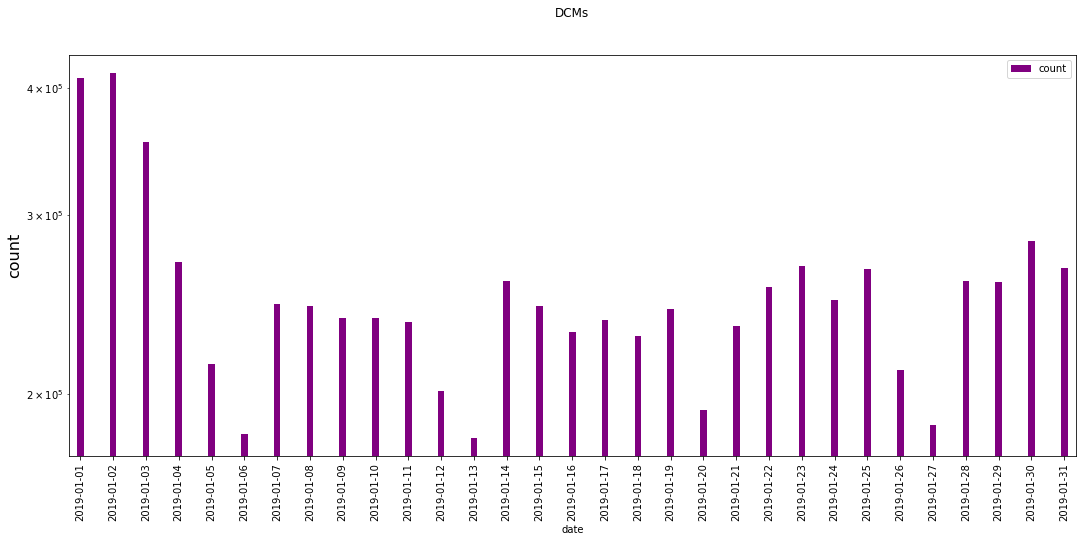

In [9]:
import matplotlib.pyplot as plt
sql="""
SELECT
  date,0 as count 
FROM
  UNNEST(GENERATE_DATE_ARRAY('2019-01-01','2019-01-31')) AS date
  where date not in ( SELECT
    DISTINCT cast (event_time as DATE)
  FROM
    `aaa-usa.dc.enriched_2019*`
  WHERE
    cast(event_time  as DATE) BETWEEN '2019-01-01'
  AND '2019-01-31')
  group by 1
  union all
SELECT
  DATE(event_time ) as day,
  COUNT(*) count
FROM
  `aaa-usa.dc.enriched_2019*`
WHERE
  DATE(event_time ) BETWEEN '2019-01-01'
  AND '2019-01-31'
GROUP BY
  1
ORDER BY
  1
"""
df=client.query(sql).to_dataframe()
ax=pd.pivot_table(df, index = 'date',values ='count').plot(kind = 'bar',title='DCMs',width=0.2,color='purple',figsize=(15,7),logy=True)
ax.set_yscale('log',basey=10)
ax.set_yticklabels(ax.get_yticks())
ax.set_ylabel(list(df)[1],fontsize=16)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#ax.set_title(ax.get_title(), fontsize=21)
ax.title.set_position((0.5,1.08))




In [ ]:
def Graph_Plot(clnt,start_date,end_date):
    print clnt
    client= bq.Client(clnt)
    fields=[];rows=[]
    
    with open("query.csv","r")  as fo:
        csvreader = csv.DictReader(fo)
        print '1111'
        for row in csvreader:
            row['Query']=row['Query'].format(client=clnt,start_date=start_date,end_date=end_date)
            try:
                df=client.query(row['Query']).to_dataframe()
            except Exception as e:
                continue
            if df.empty:
              txt= row['description']+" Files not present to Plot " +row['Title']
              print txt
              print "\n"
              continue
              print '2222'
            if row['Plot_type']=='pie':
              ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count',figsize=(5,5),title=row['Title'])
              ax.set_aspect('equal')
            elif row['Plot_type']=='stack':
              if (df[list(df)[2]] == 0).all():
                txt= row['description']+" Files not present to Plot " +row['Title']
                print txt
                print "\n"
              else:
                  ax=pd.pivot_table(df, index = list(df)[0], columns =list(df)[1], values =list(df)[2]).plot(kind = 'bar',title=row['Title'],width=0.8,figsize=(15,7),stacked=True)
                  #ax.set_yticklabels(ax.get_yticks())
                  #ax.set_yscale('log',basey=10)
                  ax.set_ylabel(list(df)[2],fontsize=16)
            else:
              if (df[list(df)[1]] == 0).all():
                txt= row['description']+" Files not present to Plot " +row['Title']
                print txt
                print "\n"
              else:
                ax=pd.pivot_table(df, index = list(df)[0],values =list(df)[1]).plot(kind = 'bar',title=row['Title'],width=0.2,color='purple',figsize=(15,7))
                ax.set_yscale('log',basey=10)
                #ax.set_yticklabels(ax.get_yticks())
                ax.set_ylabel(list(df)[1],fontsize=16)
        mp.pyplot.show()